In [26]:
# Install required libraries
!pip install PyMuPDF scikit-learn matplotlib seaborn wordcloud nltk

In [27]:
# Download NLTK data
import nltk
import os

In [28]:
# List of required NLTK resources
nltk_resources = [
    'punkt',
    'stopwords',
    'wordnet',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng'
]

In [29]:
# Download each resource and verify
for resource in nltk_resources:
    try:
        nltk.download(resource, quiet=True)
        print(f"Successfully downloaded NLTK resource: {resource}")
    except Exception as e:
        print(f"Failed to download NLTK resource {resource}: {e}")
        raise
# Verify averaged_perceptron_tagger_eng is available
try:
    from nltk.data import find
    find('taggers/averaged_perceptron_tagger_eng')
    print("averaged_perceptron_tagger_eng is available")
except LookupError:
    print("averaged_perceptron_tagger_eng not found after download attempt")
    raise

Successfully downloaded NLTK resource: punkt
Successfully downloaded NLTK resource: stopwords
Successfully downloaded NLTK resource: wordnet
Successfully downloaded NLTK resource: averaged_perceptron_tagger
Successfully downloaded NLTK resource: averaged_perceptron_tagger_eng
averaged_perceptron_tagger_eng is available


In [30]:
# Import libraries
import re
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import fitz
from sklearn.svm import LinearSVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [31]:
# Convert PDF to text
def pdf_to_text(document):
    doc = fitz.open(document)
    text = ""
    for page in doc:
        text += page.get_text()
    return text

In [32]:
# Preprocessing function
stop = stopwords.words('english')

def getWordnetPos(words):
    tag = pos_tag([words])[0][1][0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def cv_preprocessing(cv_data):
    tokenized_text = word_tokenize(cv_data)
    stop_words = set(stopwords.words('english'))
    filter_text = [token for token in tokenized_text if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatizeResults = [lemmatizer.lemmatize(token, getWordnetPos(token)) for token in filter_text]
    return ' '.join(lemmatizeResults)


In [33]:
# Feature extraction for SVM
def extract_features(tokens, pos_tags, i):
    token = tokens[i]
    features = {
        "token": token.lower(),
        "is_upper": token[0].isupper() if token else False,
        "is_digit": token.isdigit(),
        "pos": pos_tags[i][1] if i < len(pos_tags) else "",
        "len": len(token),
        "is_alpha": token.isalpha(),
        "has_special": bool(re.search(r'[^a-zA-Z0-9\s]', token)),
        "prev_token": tokens[i-1].lower() if i > 0 else "",
        "prev_pos": pos_tags[i-1][1] if i > 0 and i-1 < len(pos_tags) else "",
        "next_token": tokens[i+1].lower() if i < len(tokens)-1 else "",
        "next_pos": pos_tags[i+1][1] if i < len(tokens)-1 and i+1 < len(pos_tags) else ""
    }
    return features

In [34]:
# Generate synthetic training data for names
def generate_training_data(train_files):
    X_features = []
    y_labels = []
    for file in train_files:
        text = pdf_to_text(file)
        tokens = word_tokenize(text[:500])  # Limit to first 500 characters
        pos_tags = pos_tag(tokens)
        labels = ["O"] * len(tokens)
        # Assume first 2-3 capitalized alphabetic tokens are the name
        name_tokens = []
        for i, (token, pos) in enumerate(pos_tags):
            if len(name_tokens) < 3 and token[0].isupper() and token.isalpha() and pos.startswith('NN'):
                name_tokens.append(token)
                labels[i] = "B-NAME" if not name_tokens[:-1] else "I-NAME"
            elif name_tokens:
                break
        # Extract features for each token
        for i in range(len(tokens)):
            X_features.append(extract_features(tokens, pos_tags, i))
            y_labels.append(labels[i])
    return X_features, y_labels

In [35]:
# Train SVM model
def train_svm_model(train_files):
    X_features, y_labels = generate_training_data(train_files)
    vectorizer = DictVectorizer()
    X = vectorizer.fit_transform(X_features)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y_labels)
    svm = LinearSVC(max_iter=1000)
    svm.fit(X, y)
    return svm, vectorizer, label_encoder

In [36]:
# Extract names using SVM
def extract_names(resume_text, svm, vectorizer, label_encoder):
    tokens = word_tokenize(resume_text[:500])
    pos_tags = pos_tag(tokens)
    X_features = [extract_features(tokens, pos_tags, i) for i in range(len(tokens))]
    X = vectorizer.transform(X_features)
    y_pred = label_encoder.inverse_transform(svm.predict(X))
    names = []
    current_name = []
    for i, label in enumerate(y_pred):
        if label == "B-NAME":
            if current_name:
                names.append(" ".join(current_name))
                current_name = []
            current_name.append(tokens[i])
        elif label == "I-NAME" and current_name:
            current_name.append(tokens[i])
        else:
            if current_name:
                names.append(" ".join(current_name))
                current_name = []
    if current_name:
        names.append(" ".join(current_name))
    return names[:1] if names else None

In [37]:

# Rule-based entity extraction functions
def extract_mobile_number(resume_text):
    phone = re.findall(r'(?:(?:\+?([1-9]|[0-9][0-9]|[0-9][0-9][0-9])\s*(?:[.-]\s*)?)?(?:\(\s*([2-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9])\s*\)|([0-9][1-9]|[0-9]1[02-9]|[2-9][02-8]1|[2-9][02-8][02-9]))\s*(?:[.-]\s*)?)?([2-9]1[02-9]|[2-9][02-9]1|[2-9][02-9]{2})\s*(?:[.-]\s*)?([0-9]{4})(?:\s*(?:#|x\.?|ext\.?|extension)\s*(\d+))?', resume_text)
    if phone:
        number = ''.join(phone[0])
        return number
    return None

def extract_email(resume_text):
    pattern = r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b"
    matches = re.findall(pattern, resume_text)
    return matches

def extract_degree(resume_text):
    degree_patterns = [
        r'\b[Bb]achelor\s*(?:of\s*[A-Za-z]+)?(?:\s*[A-Za-z]+)?',
        r'\b[Mm]aster\s*(?:of\s*[A-Za-z]+)?(?:\s*[A-Za-z]+)?',
        r'\b[Pp][Hh][Dd]',
        r'\b[Dd]octor\s*of\s*[A-Za-z]+',
        r'\b[Mm][Bb][Aa]',
        r'\bBS\s*[A-Za-z]*',
        r'\bMS\s*[A-Za-z]*'
    ]
    degrees = []
    for pattern in degree_patterns:
        matches = re.findall(pattern, resume_text, re.IGNORECASE)
        degrees.extend(matches)
    return degrees

def extract_grad_years(resume_text):
    pattern = r'\b(19|20)\d{2}\b'
    years = re.findall(pattern, resume_text)
    return years
def extract_locations(resume_text):
    # Simplified: Use a small list of known locations (since no SpaCy GPE)
    location_list = ['New York', 'California', 'Texas', 'London', 'India']
    tokens = word_tokenize(resume_text)
    locations = [token for token in tokens if token in location_list]
    return locations

def extract_organization(resume_text):
    # Simplified: Match against company.txt
    with open("/kaggle/input/resume6/company.txt", "r") as f:
        companies = set(f.read().split('\n'))
    tokens = word_tokenize(resume_text)
    orgs = [token for token in tokens if token in companies]
    return orgs

def extract_company(resume_text):
    return extract_organization(resume_text)  # Same as organization for simplicity

def extract_designations(resume_text):
    with open("/kaggle/input/resume6/job-titles.txt", "r") as f:
        job_titles = set(f.read().split('\n'))
    tokens = word_tokenize(resume_text)
    designations = [token for token in tokens if token in job_titles]
    return designations

def get_skills_and_scores(resume_text):
    # Simplified: Rule-based skill extraction with a predefined list
    skill_list = [
        'Python', 'Java', 'SQL', 'C++', 'JavaScript', 'HTML', 'CSS',
        'Machine Learning', 'Data Analysis', 'Project Management'
    ]
    tokens = word_tokenize(resume_text.lower())
    skills = [token for token in tokens if token in [s.lower() for s in skill_list]]
    scores = [0.95] * len(skills)  # Dummy scores
    return skills, scores

def get_sections(text):
    summary_regex = r"(Professional Summary|Summary)"
    objective_regex = r"(Objective|Career Objective)"
    education_regex = r"(Education|Academic Background|Academic Qualifications)"
    work_experience_regex = r"(PROFESSIONAL EXPERIENCE|Work Experience|Professional Experience|(^|\n)([ \t]*)(EXPERIENCE)([ \t]*)(\n|$))"
    skills_regex = r"(Skills|Technical Skills|Computer Skills|Technical skill-set)"
    patterns = [
        (summary_regex, 'Summary'),
        (objective_regex, 'Objective'),
        (education_regex, 'Education'),
        (work_experience_regex, 'Experience'),
        (skills_regex, 'Skills')
    ]
    sections = {}
    current_position = 0
    current_header = 'Summary'
    for pattern, header in patterns:
        for match in re.finditer(pattern, text, re.IGNORECASE):
            section_text = text[current_position:match.start()].strip()
            sections[current_header] = section_text
            current_position = match.end()
            current_header = header
    section_text = text[current_position:].strip()
    sections[current_header] = section_text
    return sections

def get_skills_section(resume_text):
    sections = get_sections(resume_text)
    skills_regex = re.compile(r"(Skills|Technical Skills|Computer Skills|Technical skill-set)", re.IGNORECASE)
    skill_sections = [sections[key] for key in sections if re.match(skills_regex, key)]
    return ' '.join(skill_sections)


In [38]:
# Main NER function
import time

def ner_ml_rule(file_name, resume_text, svm, vectorizer, label_encoder):
    start_time = time.time()
    raw_text = pdf_to_text(file_name)
    name = extract_names(resume_text, svm, vectorizer, label_encoder)
    phone_num = extract_mobile_number(resume_text)
    email = extract_email(raw_text)
    qualifications = extract_degree(resume_text)
    graduated_year = extract_grad_years(resume_text)
    location = extract_locations(resume_text)
    skills, scores = get_skills_and_scores(get_skills_section(raw_text))
    university = extract_organization(resume_text)
    company = extract_company(resume_text)
    designation = extract_designations(resume_text)
    # Filter universities (simplified)
    university = [u for u in university if any(kw in u.lower() for kw in ["university", "college", "institution"])]
    print("=================================== RESULT OF ML+Rule-BASED NER ===================================")
    print("Name: ", name)
    print("\nPhone Number: ", phone_num)
    print("\nEmail: ", set(email))
    print("\nQualifications: ", qualifications)
    print("\nGraduation Year: ", set(graduated_year))
    print("\nLocation: ", set(location))
    print("\nSkills: ", set(skills))
    print("\nTotal Scores: ", sum(scores))
    print("\nUniversity: ", university)
    print("\nCompany: ", set(company))
    print("\nDesignation: ", set(designation))
    print("======================================== END OF RB+ML NER ========================================")
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Execution time: {:.2f} seconds".format(elapsed_time))
    return file_name, name, phone_num, email, qualifications, graduated_year, location, skills, university, company, designation, elapsed_time

In [39]:
# Create DataFrames
train_df = pd.DataFrame(columns=['file_name', 'name', 'phone_num', 'email', 'qualifications', 'graduated_year', 'location', 'skills', 'university', 'company', 'designation', 'execution_time'])
df = pd.DataFrame(columns=['file_name', 'name', 'phone_num', 'email', 'qualifications', 'graduated_year', 'location', 'skills', 'university', 'company', 'designation', 'execution_time'])
df2 = pd.DataFrame(columns=['file_name', 'name', 'phone_num', 'email', 'qualifications', 'graduated_year', 'location', 'skills', 'university', 'company', 'designation', 'execution_time'])


In [40]:
# Define file paths
train_files = [f"/kaggle/input/resume6/R{i}.pdf" for i in range(1, 6)]
test_files = [f"/kaggle/input/resume6/R{i}.pdf" for i in range(6, 11)]

In [41]:

# Train SVM model
svm, vectorizer, label_encoder = train_svm_model(train_files)

In [42]:
# Process training resumes (R1.pdf to R5.pdf)
for i, train_file in enumerate(train_files):
    train_df.loc[i] = ner_ml_rule(train_file, pdf_to_text(train_file), svm, vectorizer, label_encoder)

=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Abiral Pandey']

Phone Number:  9402423303

Email:  {'abiral.pandey88@gmail.com'}

Qualifications:  ['Bachelor of Computer Science']

Graduation Year:  {'20'}

Location:  {'Texas'}

Skills:  {'html', 'java', 'javascript', 'css'}

Total Scores:  5.7

University:  []

Company:  {'IBM', 'Oracle', 'Visa'}

Designation:  set()
======================================== END OF RB+ML NER ========================================
Execution time: 0.06 seconds
=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Suresh Basetti Mobile']

Phone Number:  19259003354

Email:  {'sureshkumar.basetti@gmail.com'}

Qualifications:  ['Master and', 'Master', 'Master of Computer Applications', 'Master ']

Graduation Year:  {'20'}

Location:  {'India'}

Skills:  {'c++', 'java', 'javascript'}

Total Scores:  15.199999999999996

University:  []

Compa

In [43]:
# Process test resumes without preprocessing (R6.pdf to R10.pdf)
for i, test_file in enumerate(test_files):
    df.loc[i] = ner_ml_rule(test_file, pdf_to_text(test_file), svm, vectorizer, label_encoder)

=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Gopi Mobile']

Phone Number:  17326307623

Email:  {'gopijavafullstack@gmail.com'}

Qualifications:  ['Bachelors', 'MS Visio']

Graduation Year:  {'20'}

Location:  {'India'}

Skills:  {'java', 'html', 'css', 'javascript', 'c++', 'sql'}

Total Scores:  20.89999999999999

University:  []

Company:  {'Amazon', 'NCC', 'IBM', 'Oracle'}

Designation:  {'server'}
======================================== END OF RB+ML NER ========================================
Execution time: 0.08 seconds
=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Kashyap']

Phone Number:  2015326397

Email:  {'kashyapkvora@gmail.com'}

Qualifications:  ['Master of Science in', 'MS Azure', 'MS SQL', 'MS Visio', 'MS Excel']

Graduation Year:  {'20'}

Location:  {'India'}

Skills:  {'java', 'html', 'css', 'javascript', 'python', 'sql'}

Total Scores:  6.6

In [44]:
# Process test resumes with preprocessing (R6.pdf to R10.pdf)
for i, test_file in enumerate(test_files):
    df2.loc[i] = ner_ml_rule(test_file, cv_preprocessing(pdf_to_text(test_file)), svm, vectorizer, label_encoder)

=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Gopi Mobile']

Phone Number:  17326307623

Email:  {'gopijavafullstack@gmail.com'}

Qualifications:  ['Bachelors', 'MS Visio']

Graduation Year:  {'20'}

Location:  {'India'}

Skills:  {'java', 'html', 'css', 'javascript', 'c++', 'sql'}

Total Scores:  20.89999999999999

University:  []

Company:  {'Amazon', 'NCC', 'IBM', 'Oracle'}

Designation:  {'server'}
======================================== END OF RB+ML NER ========================================
Execution time: 0.08 seconds
=================================== RESULT OF ML+Rule-BASED NER ===================================
Name:  ['Kashyap']

Phone Number:  2015326397

Email:  {'kashyapkvora@gmail.com'}

Qualifications:  ['Master Science', 'MS Azure', 'MS SQL', 'MS Visio', 'MS Excel']

Graduation Year:  {'20'}

Location:  {'India'}

Skills:  {'java', 'html', 'css', 'javascript', 'python', 'sql'}

Total Scores:  6.65

Uni

In [45]:
train_df

,file_name,name,phone_num,email,qualifications,graduated_year,location,skills,university,company,designation,execution_time
0,/kaggle/input/resume6/R1.pdf,[Abiral Pandey],9402423303,[abiral.pandey88@gmail.com],[Bachelor of Computer Science],"[20, 20, 20, 20, 20, 20, 20, 20, 20]","[Texas, Texas]","[html, css, javascript, java, java, java]",[],"[Visa, Oracle, IBM, Oracle, Oracle, Oracle]",[],0.060458
1,/kaggle/input/resume6/R2.pdf,[Suresh Basetti Mobile],19259003354,[sureshkumar.basetti@gmail.com],"[Master and, Master, Master of Computer Applic...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20]","[India, India, India, India, India, India]","[java, java, javascript, java, c++, java, java...",[],"[HP, Oracle, TCS, HP, TCS, TCS, Broadcom, Orac...",[],0.070795
2,/kaggle/input/resume6/R3.pdf,[Chandler Robert Durairaj],5152573838,[chandler.neel@gmail.com],"[Master experience, Master, Master of Business...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India, India, India]","[sql, sql, html, css]",[],"[Microsoft, Microsoft]",[],0.069070
3,/kaggle/input/resume6/R4.pdf,[Deepika Chintalapati Mobile],5188059569,[chintalapatideepika@gmail.com],"[Bachelor of Computer Science, Masters, MS Pro...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India, India, India, India, India]","[sql, sql, sql, sql, sql]",[],"[Oracle, ServiceNow, Oracle, Oracle, Oracle, O...","[server, server, server]",0.074844
4,/kaggle/input/resume6/R5.pdf,[Mounika Kalmekolan Mobile],4149090756,[Mounika10200@gmail.com],"[Bachelors, Masters, Masters, MS O, MS Project...",[],[India],[sql],[],"[HP, Oracle]",[],0.050753


In [46]:
df

,file_name,name,phone_num,email,qualifications,graduated_year,location,skills,university,company,designation,execution_time
0,/kaggle/input/resume6/R6.pdf,[Gopi Mobile],17326307623,[gopijavafullstack@gmail.com],"[Bachelors, MS Visio]","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India]","[java, javascript, c++, sql, java, java, java,...",[],"[Oracle, Oracle, IBM, Oracle, Oracle, Amazon, ...",[server],0.083286
1,/kaggle/input/resume6/R7.pdf,[Kashyap],2015326397,[kashyapkvora@gmail.com],"[Master of Science in, MS Azure, MS SQL, MS Vi...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",[India],"[python, sql, javascript, java, sql, html, css]",[],"[IBM, Oracle, Oracle, Splunk, ServiceNow, HP, ...","[server, server, server]",0.081116
2,/kaggle/input/resume6/R8.pdf,[0pt12pt],5163581998,[mike@sqldatasolutionsinc.com],"[Bachelor, MS SQL]","[19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India]","[java, sql, c++, java, javascript, sql, java, ...",[],"[Oracle, Oracle, Microsoft, IBM, IBM, Oracle, ...",[],0.077412
3,/kaggle/input/resume6/R9.pdf,[Nandini],16463611031,"[JNandini1324@gmail.com, JNandini1324@gmail.com]","[Bachelor of Technology, Master of Science, MS...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",[],[],[],"[Oracle, Oracle, Oracle, Symphony, Oracle, Ora...","[manager, partner, driver, partner]",0.121410
4,/kaggle/input/resume6/R10.pdf,[Rama],5163081026,[ramglobal5111@gmail.com],[Bachelor],"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]","[India, India, India]","[java, c++, javascript, css, html, html, css, ...",[],"[Oracle, Oracle, Oracle, Oracle, Oracle, Oracl...",[],0.070092


In [47]:
df2

,file_name,name,phone_num,email,qualifications,graduated_year,location,skills,university,company,designation,execution_time
0,/kaggle/input/resume6/R6.pdf,[Gopi Mobile],17326307623,[gopijavafullstack@gmail.com],"[Bachelors, MS Visio]","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India]","[java, javascript, c++, sql, java, java, java,...",[],"[Oracle, Oracle, IBM, Oracle, Oracle, Amazon, ...",[server],0.081680
1,/kaggle/input/resume6/R7.pdf,[Kashyap],2015326397,[kashyapkvora@gmail.com],"[Master Science, MS Azure, MS SQL, MS Visio, M...","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",[India],"[python, sql, javascript, java, sql, html, css]",[],"[IBM, Oracle, Oracle, Splunk, ServiceNow, HP, ...","[server, server, server, author, server]",0.083423
2,/kaggle/input/resume6/R8.pdf,[0pt12pt],5163581998,[mike@sqldatasolutionsinc.com],"[Bachelor , MS SQL]","[19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[India, India, India]","[java, sql, c++, java, javascript, sql, java, ...",[],"[Oracle, Oracle, Microsoft, IBM, IBM, Oracle, ...",[],0.075971
3,/kaggle/input/resume6/R9.pdf,[Nandini],16463611031,"[JNandini1324@gmail.com, JNandini1324@gmail.com]","[Bachelor Technology, Master Science, MSSQL]","[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",[],[],[],"[Oracle, Oracle, Oracle, Symphony, Oracle, Ora...","[manager, partner, architect, partner, driver,...",0.115540
4,/kaggle/input/resume6/R10.pdf,[Rama],5163081026,[ramglobal5111@gmail.com],[Bachelor ],"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]","[India, India, India]","[java, c++, javascript, css, html, html, css, ...",[],"[Oracle, Oracle, Oracle, Oracle, Oracle, Oracl...",[],0.068235


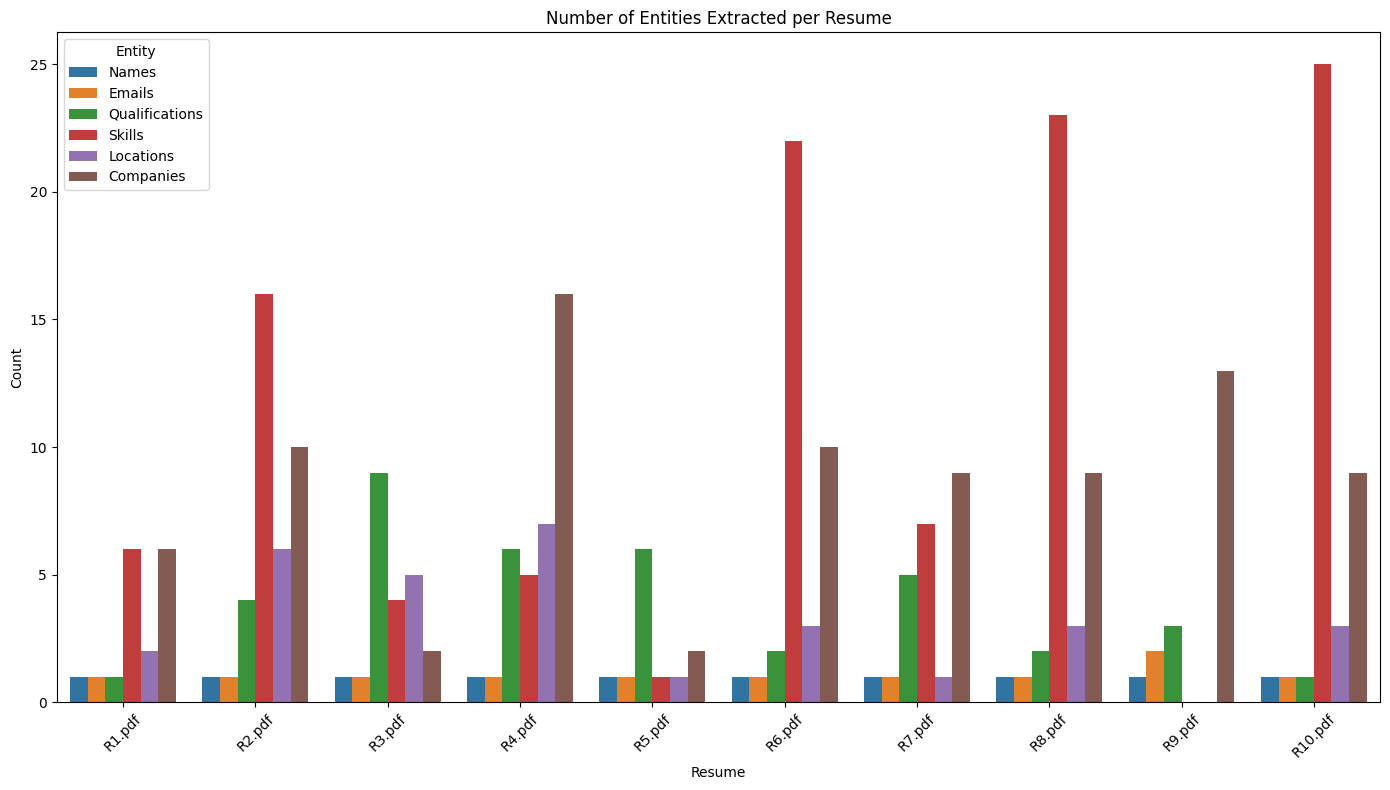

In [48]:
# Visualizations
# 1. Bar Chart: Number of entities per resume
def count_entities(df):
    counts = {
        'Resume': [],
        'Names': [],
        'Emails': [],
        'Qualifications': [],
        'Skills': [],
        'Locations': [],
        'Companies': []
    }
    for idx, row in df.iterrows():
        counts['Resume'].append(row['file_name'].split('/')[-1])
        counts['Names'].append(len(row['name']) if row['name'] else 0)
        counts['Emails'].append(len(row['email']) if row['email'] else 0)
        counts['Qualifications'].append(len(row['qualifications']) if row['qualifications'] else 0)
        counts['Skills'].append(len(row['skills']) if row['skills'] else 0)
        counts['Locations'].append(len(row['location']) if row['location'] else 0)
        counts['Companies'].append(len(row['company']) if row['company'] else 0)
    return pd.DataFrame(counts)

# Combine all DataFrames for visualization
all_dfs = pd.concat([train_df.assign(Dataset='Train'), df.assign(Dataset='Test (No Preprocessing)'), df2.assign(Dataset='Test (Preprocessed)')])

# Bar Chart
entity_counts = count_entities(all_dfs)
plt.figure(figsize=(14, 8))
entity_counts_melted = entity_counts.melt(id_vars='Resume', value_vars=['Names', 'Emails', 'Qualifications', 'Skills', 'Locations', 'Companies'], var_name='Entity', value_name='Count')
sns.barplot(data=entity_counts_melted, x='Resume', y='Count', hue='Entity')
plt.title('Number of Entities Extracted per Resume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/kaggle/working/entity_counts_bar.png')
plt.show()


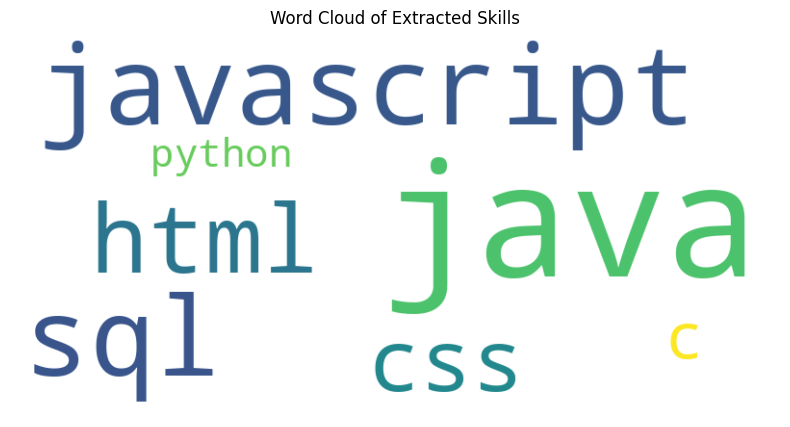

In [50]:
# 4. Word Cloud: Frequent skills
all_skills = []
for df_subset in [train_df, df, df2]:
    for skills in df_subset['skills']:
        if skills:
            all_skills.extend(skills)
skill_text = ' '.join(all_skills)
wordcloud = WordCloud(width=800, height=400, background_color='white', min_font_size=10).generate(skill_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Extracted Skills')
plt.savefig('/kaggle/working/skills_wordcloud.png')